In [1]:
# %load_ext pycodestyle_magic
# %flake8_on
# import logging
# logging.getLogger("flake8").setLevel(logging.FATAL)

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Citzen Science Notebook</b> <br>
Contact author: Sreevani Jarugula and Becky Nevin<br>
Last verified to run: 2023-04-20 <br>
LSST Science Pipelines version: Weekly 2023_xx <br>
Container size: medium <br>


**Description:**
Query and send variable star images and light curves from RSP to Zooniverse

**Skills:** Use various TAP tables, including joining multiple tables. Get calexp images. Extract time-series photometry.

**LSST Data Products:** TAP tables dp02_dc2_catalogs.MatchesTruth, TruthSummary, ForcedSource, CcdVisit<br>

**Packages:** astropy, lsst.rsp.get_tap_service, lsst.rsp.retrieve_query, lsst.daf.butler, lsst.afw.display, lsst.geom 

**Credit:** Tutorial notebooks 03a, 04a, 04b, 07b, and 08

**Support:** Support is available and questions are welcome - (some email/link etc)

DEBUG VERSION note that this version of the notebook contains additional debugging and the first cell will need to be run once

## 1. Introduction <a class="anchor" id="first-bullet"></a>
This notebook will guide you through the process of sending variable star data from the Rubin Science Platform (RSP) to the Zooniverse.

This notebook will restrict the number of object sent to the Zooniverse to one variable star over five exposures. This limit is intended to demonstrate your project prior to full approval from the education and public outreach (EPO) Data Rights Panel.

### 1.1 Package imports <a class="anchor" id="second-bullet"></a>

#### Install Pipeline Package

First, install the Rubin Citizen Science Pipeline package by doing the following:

1. Open up a New Launcher tab
2. In the "Other" section of the New Launcher tab, click "Terminal"
3. Use `pip` to install the `rubin.citsci` package by entering the following command:
```
pip install rubin.citsci
```
4. Confirm the next cell containing `from rubin.citsci import pipeline` works as expected and does not throw an error

!pip install --upgrade --force-reinstall --no-deps rubin.citsci --quiet

In [37]:
import utils
from matplotlib import image as mpimg
import matplotlib.pyplot as plt
import gc
import numpy as np
import pandas
import pandas as pd
import time
import os

# Astropy imports
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb
from astropy import units as u
from astropy.coordinates import SkyCoord

# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service, retrieve_query

# Image visualization routines.
import lsst.afw.display as afwDisplay
# The Butler provides programmatic access to LSST data products.
from lsst.daf.butler import Butler
# Geometry package
import lsst.geom as geom
# Object for multi-band exposures
from lsst.afw.image import MultibandExposure

import lsst.daf.butler as dafButler
import lsst.geom
import lsst.afw.display as afwDisplay

# Must explicitly set this to save figures
afwDisplay.setDefaultBackend("matplotlib")


### 1.2 Define functions and parameters <a class="anchor" id="third-bullet"></a>
If you haven't already, [create a Zooniverse account](https://www.zooniverse.org/accounts/registerhttps://www.zooniverse.org/accounts/register) and create your project.

IMPORTANT: Your Zooniverse project must be set to "public", a "private" project will not work. Select this setting under the "Visibility" tab, (it does not need to be set to live). 


A "slug" is the string of your Zooniverse username and your project name without the leading forward slash, for instance: "username/project-name". [Click here for more details](https://www.zooniverse.org/talk/18/967061?comment=1898157&page=1).


In [3]:
# %load_ext pycodestyle_magic
# %flake8_on
# import logging
# logging.getLogger("flake8").setLevel(logging.FATAL)
email = "beckynevin@gmail.com"  
# slug_name = "sreevani/test-pcw23" 
slug_name = "rebecca-dot-nevin/test-project" 

from rubin.citsci import pipeline
print("Loading and running utilities to establish a link with Zooniverse")
print("Enter your Zooniverse username followed by password below")
cit_sci_pipeline = pipeline.CitSciPipeline()
cit_sci_pipeline.login_to_zooniverse(slug_name, email)

Loading and running utilities to establish a link with Zooniverse
Enter your Zooniverse username followed by password below
Enter your Zooniverse credentials...


Username:  rebecca.nevin
 ········


You now are logged in to the Zooniverse platform.


## 2. Make a subject set of variable stars to send to Zooniverse <a class="anchor" id="fourth-bullet"></a>
A subject set is a collection of data (images, plots, etc) that are shown to citizen scientists. It is also the unit of data that is sent to Zooniverse.

Here, we curate the subject set of objects to send to Zooniverse. This can be modified to create your own subject set. Your subject set must have 100 objects or less in the testing phase before your project is approved by the EPO Data Rights panel. 

This example makes two sets of image cutouts of two different variable stars at different moments in time.

### 2.1 Initialize TAP and Butler

In [5]:
config = 'dp02'
collection = '2.2i/runs/DP0.2'
service, butler, skymap = utils.setup_butler(config, collection)

### 2.2 Define variable star related parameters

In [22]:
query_num_stars = 2 # number of variable stars to query 

# Set any RA and DEC in degrees. This is the centre of your search radius
# In this example notebook we are looking at one known RR-Lyrae. 

ra_known_rrl = 62.1479031
dec_known_rrl = -35.799138

search_radius = 0.001 # Search radius in degrees

num_variable_images = 5 # For each variable stars, number of images to query to create flipbook (gif)

image_size = 20 # image size for cutouts

bands = ['g','r','i'] # bands to get flux for to create a lightcurve

### 2.3 Create relevant directories

In [23]:
plots = [] # empty list for plots

# main directory
batch_dir = './variable_stars_output/' 

if os.path.isdir(batch_dir) == False:
    os.mkdir(batch_dir)

# cutouts directory
if os.path.isdir(batch_dir+'images') == False:
    os.mkdir(batch_dir+'images')
else:
    os.system('rm -r '+batch_dir+'images/*')

# light curve directory
if os.path.isdir(batch_dir+'lc_plots') == False:
    os.mkdir(batch_dir+'lc_plots')
else:
    os.system('rm -r '+batch_dir+'lc_plots/*')

# light curve text file directory
if os.path.isdir(batch_dir+'text_files') == False:
    os.mkdir(batch_dir+'text_files')
else:
    os.system('rm -r '+batch_dir+'text_files/*')

### 2.4 Query and Plotting functions

In [24]:
def query_stars(ra_deg, dec_deg, radius_deg, limit):
    """
    Query variable stars from dp02_dc2_catalogs.MatchesTruth and dc2_catalogs.TruthSummary
    
    To query more than one star within the circle of search, change = 1 to <= 1
    
    Selecting stars (truth_type=2)
    variable (is_variable = 1)
    is_pointsource = 1

    Input Parameters
    ----------
    ra_deg : ra of the centre of search in degrees
    dec_deg : dec of the centre of search in degrees
    radius_deg : radius within which to search for
    limit : number of variable stars to retireve
    
    Returns
    ----------
    Table of variable stars as pandas dataframe
    """
    query = "SELECT mt.id_truth_type, mt.match_objectId, ts.ra, ts.dec "\
            "FROM dp02_dc2_catalogs.MatchesTruth AS mt "\
            "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "\
            "WHERE ts.truth_type=2 "\
            "AND ts.is_variable = 1 "\
            "AND ts.is_pointsource = 1 "\
            "AND mt.match_objectId > 1 "\
            "AND CONTAINS(POINT('ICRS', ts.ra, ts.dec), CIRCLE('ICRS', "+ str(ra_deg)+", "+str(dec_deg)+", "+str(radius_deg)+")) <= 1 "\
            "LIMIT "+str(limit)+" "
    results = service.search(query)
    variable_stars = results.to_table().to_pandas()
    return variable_stars

def query_flux(objid):
    """
    Query to get the flux for each variable star at all bands

    Input Parameters
    ----------
    objid : Object ID of the variable star obtained from query_stars
    
    Returns
    ----------
    Table of flux of variable star 
    """
    query = "SELECT src.band, src.ccdVisitId, src.coord_ra, src.coord_dec, "\
            "src.objectId, src.psfFlux, src.psfFluxErr, "\
            "visinfo.detector, visinfo.visitId, "\
            "scisql_nanojanskyToAbMag(psfFlux) as psfMag, "\
            "visinfo.band, "\
            "visinfo.expMidptMJD "\
            "FROM dp02_dc2_catalogs.ForcedSource as src "\
            "JOIN dp02_dc2_catalogs.CcdVisit as visinfo "\
            "ON visinfo.ccdVisitId = src.ccdVisitId "\
            "WHERE src.objectId = "+str(objid)+" "
    table = service.search(query)
    flux_table = table.to_table()
    return flux_table

## 3. Query and plot the variable stars

In [25]:
%%time
variable_stars = query_stars(ra_known_rrl, dec_known_rrl, search_radius, query_num_stars)

CPU times: user 52.3 ms, sys: 3.73 ms, total: 56 ms
Wall time: 1.16 s


In [26]:
variable_stars

,id_truth_type,match_objectId,ra,dec
0,40901175128_2,1251270620688185342,62.048714,-44.533824
1,40969412329_2,1251270620688185329,62.101689,-44.534840


### 2.1 Get Calexp images and Lightcurves

How to create csv for Zooniverse flipbook

https://help.zooniverse.org/getting-started/example/#details-subject-sets-and-manifest-details-aka-what-is-a-manifesthttps://help.zooniverse.org/getting-started/example/#details-subject-sets-and-manifest-details-aka-what-is-a-manifestCreate 


In [27]:
def get_cutout_image(butler, ra_deg, dec_deg, visit, detector, band, cutoutSideLength, datasetType='calexp'):
    """
    Get the cutout image information from butler. 
    This shoudl be followed by make_fig

    Input Parameters
    ----------
    ra : ra of source in degrees
    dec : dec of source in degrees
    visit : visit id
    detector : detector number
    band : band to get cutput for
    cutoutSideLength : size of the cutout
    
    Returns
    ----------
    Cutout image information
    """
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)
    
    radec = geom.SpherePoint(ra_deg,dec_deg, geom.degrees)
    
    dataId = {'visit': visit, 'detector': detector}  
    calexp_wcs = butler.get('calexp.wcs', **dataId)
    
    print('calexp wcs: ', calexp_wcs)
    
    xy = geom.PointI(calexp_wcs.skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    parameters = {'bbox': bbox}
    print('xy: ',xy)
    print('bbox: ',bbox)
    
    cutout_image = butler.get('calexp', parameters=parameters, **dataId)
    
    return cutout_image
    
    
def make_calexp_fig(cutout_image, ra, dec, out_name):
    """
    Create an image.
    should be followed with remove_figure
    
    Parameters
    ----------
    cutout_image : cutout_image from butler.get
    ra : ra of source in degrees
    dec : dec of source in degrees
    out_name : file name where you'd like to save it
    
    Returns
    ----------
    cutout image
    """
    # fig = plt.figure(figsize=(4, 4))
    # afw_display = afwDisplay.Display(frame=fig)
    # afw_display.scale('asinh', 'zscale')
    # afw_display.mtv(cutout_image.image)
    
#     cutout_wcs = cutout_image.getWcs()
#     radec = geom.SpherePoint(ra, dec, geom.degrees)
#     xy = geom.PointI(cutout_wcs.skyToPixel(radec))
    
#     afw_display.dot('x', xy.getX(), xy.getY(), size=1, ctype='orange')
#     plt.gca().axis('off')
#     plt.savefig(out_name)
    
    fig = plt.figure()
    plt.subplot(projection=WCS(cutout_image.getWcs().getFitsMetadata()))
    
    #print('wcs ra: ', cutout_image.getWcs().getFitsMetadata()['CRVAL1'])
    #print('wcs dec: ', cutout_image.getWcs().getFitsMetadata()['CRVAL2'])
    
    calexp_extent = (cutout_image.getBBox().beginX, cutout_image.getBBox().endX,
                 cutout_image.getBBox().beginY, cutout_image.getBBox().endY)
    im = plt.imshow(cutout_image.image.array, cmap='gray', vmin=-200.0, vmax=1000,
                extent=calexp_extent, origin='lower')
    plt.colorbar(location='right', anchor=(0, 0.1))
    # plt.gca().axis('off')
    plt.xlabel('Right Ascension')
    plt.ylabel('Declination')
    plt.savefig(out_name)
    
    return fig


In [28]:
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}
plot_filter_labels = {'u':'u', 'g':'g', 'r':'r', 'i':'i', 'z':'z', 'y':'y'}
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
def plotlc(bands, days, magnitudes, out_name):
    """
    Create a light curve.

    Input Parameters
    ----------
    days : dictionary for MJD in each band 
    magnitudes : dictionary for flux in each band
    out_name : file name where you'd like to save it
    
    Returns
    ----------
    light curve image
    """

    fig = plt.figure(figsize=(10,4))
    for band in bands:
        plt.plot(days[band], magnitudes[band] - np.mean(magnitudes[band]),\
                 plot_filter_symbols[band], ms=4, label=plot_filter_labels[band])
    plt.minorticks_on()
    plt.xlabel('MJD (days)')
    plt.ylabel('magnitude')
    plt.legend('upper right')
    plt.legend()
    plt.savefig(out_name)
    return fig

def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.
    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.
    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure

    gc.collect()    # call th

In [32]:
stars_matchid = variable_stars['match_objectId'].to_numpy()
stars_ra = variable_stars['ra'].to_numpy()
stars_dec = variable_stars['dec'].to_numpy()

df_row = []
df_final = []

fields_to_add = ["sourceId", "coord_ra", "coord_dec"] # fields to add to the maifest file

for j, objid in enumerate(stars_matchid):
# for j, objid in enumerate(["1251270620688185329"]):
    cutouts = []
    
    figout_data = {"sourceId": stars_matchid[j]}
    if "coord_ra" in fields_to_add:
        figout_data["coord_ra"] = stars_ra[j]
    if "coord_dec" in fields_to_add:
        figout_data["coord_dec"] = stars_dec[j]
    
    # Query the variable star flux, detector and visit information
    ccd_flux_table = query_flux(objid)
    
    # Get calexp images from Butler and plot them
    idx_images = np.round(np.linspace(0, len(ccd_flux_table) - 1, num_variable_images)).astype(int)  #randomly select 5 images for each variable star
    image_dict = {} 
    
    for i,idx in enumerate(idx_images):
        star_ra = ccd_flux_table['coord_ra'][idx]
        star_dec = ccd_flux_table['coord_dec'][idx]
        star_detector = ccd_flux_table['detector'][idx]
        star_visitid = ccd_flux_table['visitId'][idx]
        star_id = ccd_flux_table['objectId'][idx]
        star_ccdid = ccd_flux_table['ccdVisitId'][idx]
        
        calexp_image = get_cutout_image(butler, star_ra, star_dec, star_visitid, star_detector, 'r', image_size, datasetType='calexp') # only r-band images 
        figout = make_calexp_fig(calexp_image, star_ra,star_dec,batch_dir+"/images/"+str(star_id)+"_"+str(star_ccdid)+".png")
        remove_figure(figout)
        
        figout_data['location:image_'+str(i)] = str(star_id)+"_"+str(star_ccdid)+".png"
        figout_data['filename'] = str(star_id)+"_"+str(star_ccdid)+".png"
        
    cutouts.append(figout_data)
    
    # manifest file
    df_star = pd.DataFrame(data = cutouts, index=[0])
    df_final.append(df_star)
    
    # flipbook data for each variable star
    df = pd.DataFrame(data = image_dict, index=[0])
    df_row.append(df)
        
    # Light curve for each variable star    
    mjd_days, mags = utils.get_flux(ccd_flux_table)
    figout = utils.plotlc(bands, mjd_days, mags, batch_dir+"/lc_plots/"+"lc_"+str(objid)+".png")
    remove_figure(figout) 
    df_all_bands = []
    for band in bands:
        df = pd.DataFrame(data = {'band': [band]*len(mjd_days[band]), 'mjd_days': mjd_days[band], \
                          'mags': mags[band]}, index=None)
        df_all_bands.append(df)
    
    df_final_lc = pd.concat(df_all_bands)
    outfile = batch_dir+"/text_files/"+"lc_"+str(objid)+".csv"
    df_final_lc.to_csv(outfile, index=False, sep=',')
    
df_manifest = pd.concat(df_final) # final manifest file with all variable stars
outfile = batch_dir+"images/manifest.csv"
df_manifest.to_csv(outfile, index=False, sep=',')


[62.0487137 62.1016891] [-44.5338241 -44.5348403]


NameError: name 'STOP' is not defined

## Make an image of what you're doing
Separating the two stars

[1251270620688185342 1251270620688185329]
star 1251270620688185342
['1251270620688185342', '679503053.png']


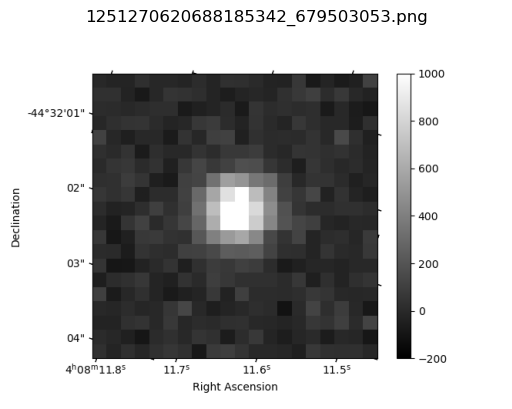

['1251270620688185342', '1184834107.png']


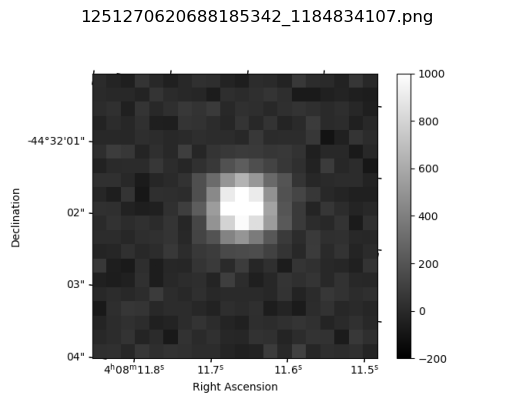

['.ipynb', 'checkpoints']
['1251270620688185342', '1187410055.png']


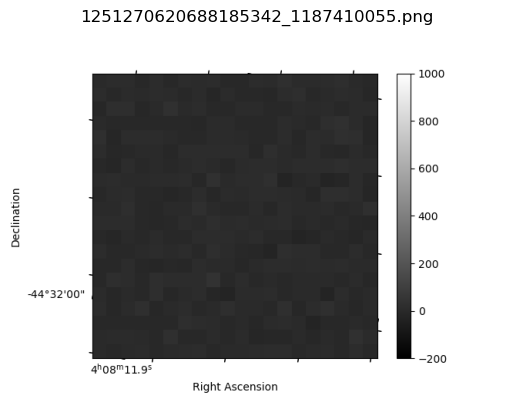

['1251270620688185329', '415005171.png']
['1251270620688185342', '511883110.png']


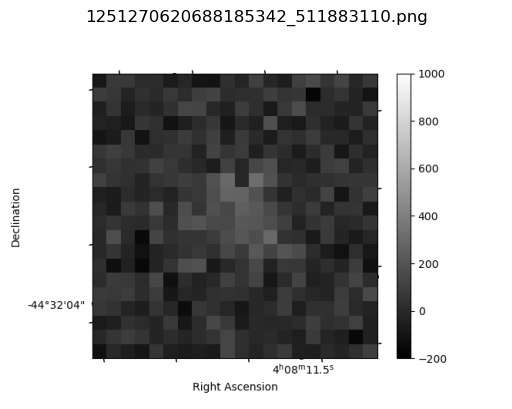

['1251270620688185329', '212255050.png']
['1251270620688185329', '184883119.png']
['1251270620688185329', '994294051.png']
['1251270620688185342', '184883119.png']


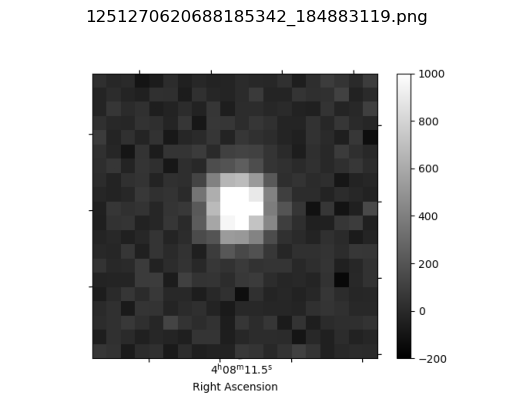

['manifest.csv']
['1251270620688185329', '1187410055.png']
star 1251270620688185329
['1251270620688185342', '679503053.png']
['1251270620688185342', '1184834107.png']
['.ipynb', 'checkpoints']
['1251270620688185342', '1187410055.png']
['1251270620688185329', '415005171.png']


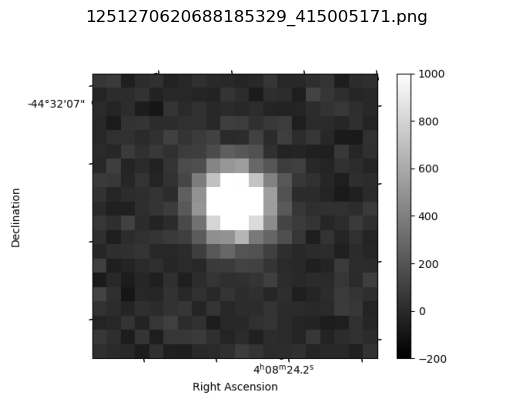

['1251270620688185342', '511883110.png']
['1251270620688185329', '212255050.png']


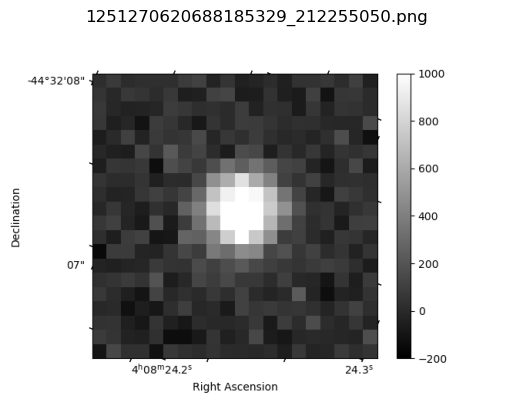

['1251270620688185329', '184883119.png']


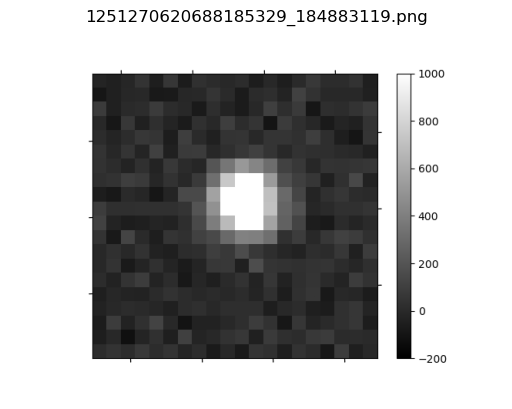

['1251270620688185329', '994294051.png']


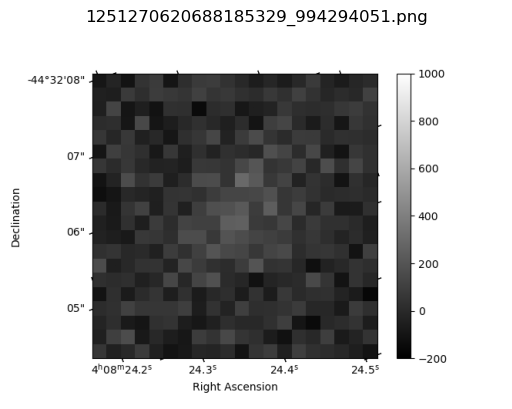

['1251270620688185342', '184883119.png']
['manifest.csv']
['1251270620688185329', '1187410055.png']


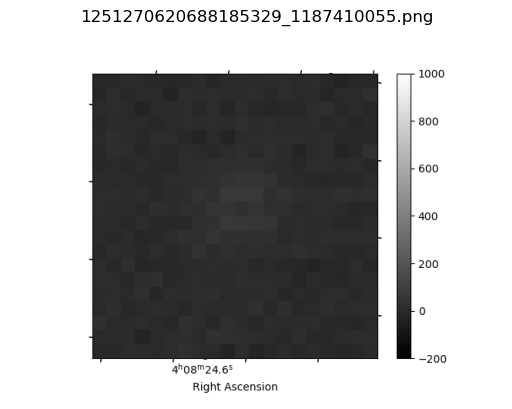

In [46]:
print(stars_matchid)

image_dir = 'variable_stars_output/images/'
for id_star in stars_matchid:
    print('star', id_star)
    # go through and sort by ccdID so that they are in order of time
    # DOUBLE CHECK THAT THIS IS TIME ORDER
    
    
    for file in os.listdir(image_dir):
        print(str.split(file,'_'))
        if str.split(file,'.')[1] == 'png' and str.split(file,'_')[0]==str(id_star):
            #try:
            plt.title(file)
            image = mpimg.imread(image_dir + file)
            #print(image)
            plt.imshow(image)
            plt.axis('off')
            plt.show()
        else:
            continue
        #except:
        #continue

In [16]:
# cutout_dir = batch_dir+"images/"

In [17]:
# manifest_path = write_metadata_file(cutouts, cutout_dir)

# print("The manifest CSV file can be found at the following relative path:")
# print(manifest_path)

## 3. Send data to Zooniverse

In [18]:
cutout_dir = batch_dir+"images/"

In [19]:
subject_set_name = "test_flipbook" 

In [20]:
cit_sci_pipeline.send_image_data(subject_set_name, cutout_dir)

'1. Checking batch status'

'2. Zipping up all the astro cutouts - this can take a few minutes with large data sets, but unlikely more than 10 minutes.'

'3. Uploading the citizen science data'

'4. Creating a new Zooniverse subject set'

'5. Notifying the Rubin EPO Data Center of the new data, which will finish processing of the data and notify Zooniverse'

'** Additional information:'

'6. Sending the manifest URL to Zooniverse'

'** Information: subject_set.id: 116642; manifest: https://storage.googleapis.com/citizen-science-data-public/3f5e8afd-ba72-4bf0-ad1f-818d19e8eb91/manifest.csv'

'7. Transfer process complete, but further processing is required on the Zooniverse platform and you will receive an email at beckynevin@gmail.com'